In [118]:

import tifffile as tiff
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage.measure import label,regionprops, regionprops_table
from skimage.measure import regionprops
from skimage.util import map_array
import numpy as np
import rasterio
from rasterio.features import geometry_mask
import rasterio.mask
import rasterstats 
from rasterio.mask import mask

In [119]:
# pip install rasterio
#pip install rasterstats

In [120]:
#read the data
def read_data(rgb_path, nir_path,parcel_path, building_path):
    # Read the raster data
    with rasterio.open(rgb_path) as src:
        rgb = src.read()  # Read all bands (rows, columns)
        rgb = np.transpose(rgb, (1, 2, 0)) # Change the order of the bands to (rows, columns, bands)


    with rasterio.open(nir_path) as src:
        nir = src.read(1) 

    # Read the vector data
    parcels = gpd.read_file(parcel_path)
    buildings = gpd.read_file(building_path)
    
    #ensure the data have the same coordinate system
    buildings = buildings.to_crs(src.crs)
    parcels = parcels.to_crs(src.crs)

    return rgb, nir, parcels, buildings,src

In [121]:
#input paths
rgb_path='/kaggle/input/ubicube-work-sample/aerial/AOI_ID_1_ortho_cog_RGB.tif'
nir_path='/kaggle/input/ubicube-work-sample/aerial/AOI_ID_1_ortho_cog_NIR.tif'
bld_path='/kaggle/input/ubicube-work-sample/building_footprints/building_footprints.geojson'
par_path='/kaggle/input/ubicube-work-sample/parcels/parcels.shp'

#output_path
output_path = "/kaggle/working/parcels_unsealing_potential.shp"

rgb, nir, parcels, buildings,src = read_data(rgb_path, nir_path,par_path, bld_path)

/tmp/ipykernel_30/4073409342.py:14: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend(loc="upper right")


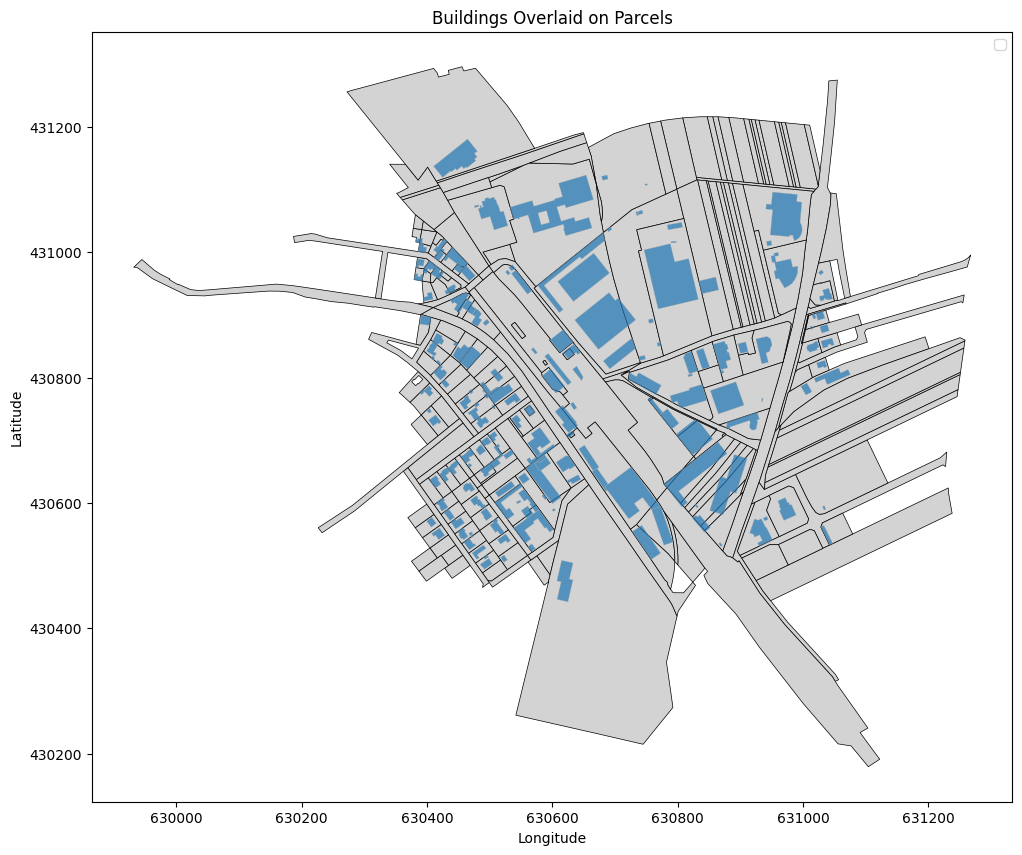

In [122]:
# Visualize the vector data
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

# Plot the reference layer with a simple style
parcels.plot(ax=ax, color="lightgrey", edgecolor="black", linewidth=0.5, label="Parcels")

# Plot the parcels with unsealing potential using a color map
buildings.plot( edgecolor="darkgrey", linewidth=0.3, legend=True, ax=ax, alpha=0.7)

# Add titles, legend, and labels
plt.title("Buildings Overlaid on Parcels")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(loc="upper right")

# Show plot
plt.show()

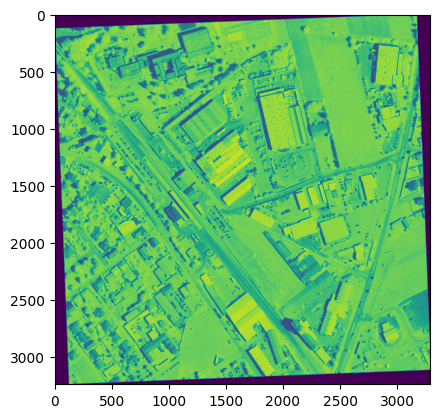

In [123]:
plt.imshow(nir)

In [124]:
# Extract the bands
red = rgb_transposed[:, :, 0]
green = rgb_transposed[:, :, 1]
blue = rgb_transposed[:, :, 2]

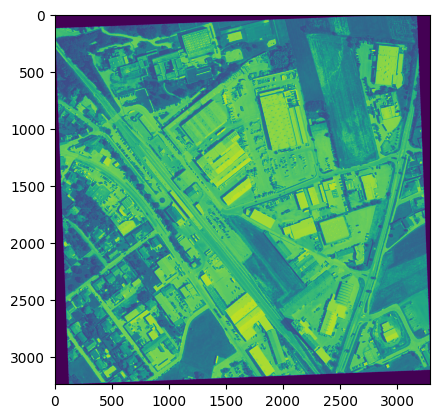

In [125]:
plt.imshow(blue)

In [126]:
# Normalize the bands
red_norm = (red - np.min(red)) / (np.max(red) - np.min(red))
green_norm = (green - np.min(green)) / (np.max(green) - np.min(green))
blue_norm = (blue - np.min(blue)) / (np.max(blue) - np.min(blue))
nir_norm =  (nir - np.min(nir)) / (np.max(nir) - np.min(nir))

In [127]:
#compute ndvi and adjust for scenarios where you might have to divide by 0
denominator_zero_mask = (nir_norm + red_norm) == 0
ndvi = np.where(denominator_zero_mask, 0, (nir_norm - red_norm) / (nir_norm + red_norm))

/tmp/ipykernel_30/3014384168.py:3: RuntimeWarning: invalid value encountered in divide
  ndvi = np.where(denominator_zero_mask, 0, (nir_norm - red_norm) / (nir_norm + red_norm))


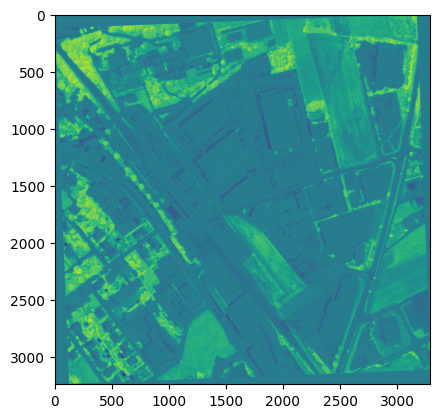

In [128]:
plt.imshow(ndvi)

In [129]:
#object based image segmentation, using the SLIC algorithm
def image_segmentation(image, algorithm='slic', algorithm_params=None, channel_axis=-1):
    if algorithm_params is None:
        algorithm_params = {}

    # Perform segmentation
    segments_result = slic(image, **algorithm_params, channel_axis=channel_axis)
    
    # Mark boundaries on the original image using the segmented result
    boundaries = mark_boundaries(image[:, :, [0, 1, 2]], segments_result, (1,0,0), mode="thick")

    return segments_result, boundaries

In [130]:
#Function to plot the segments

def plot_segments(image,segments,boundaries):
        # Display the original image and the segmentation result
    fig, ax = plt.subplots(1, 3, figsize=(12, 6))

    ax[0].imshow(image[:,:,[0,1,2]])
    ax[0].set_title(f'Tile')

    ax[1].imshow(segments)
    ax[1].set_title(f'Segments_Tile')

    ax[2].imshow(boundaries)
    ax[2].set_title(f'Segments with boundaries')

    plt.show()

In [131]:
#segment the image: testing various parameter values
slic_params = {'n_segments': 1000, 'compactness': 0.5}
algorithm='slic'
segments, boundaries = image_segmentation(image1, algorithm=algorithm, algorithm_params=slic_params)

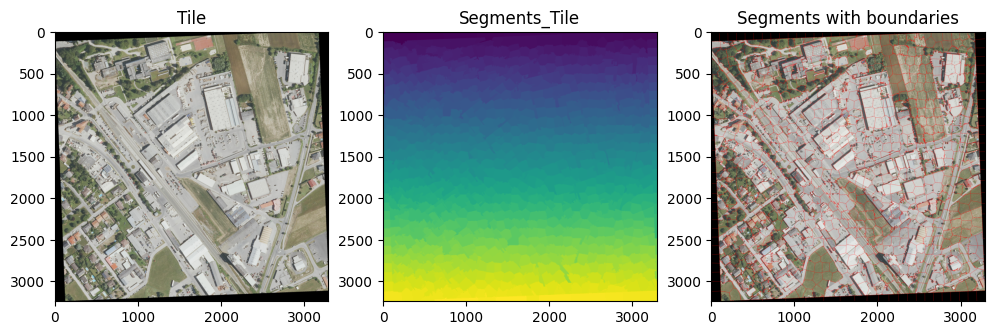

In [132]:
plot_segments(image1,segments, boundaries)

In [133]:


# # Calculate ndvi values for each segment
# segment_props = regionprops(segments, intensity_image=ndvi)

# # Extract the mean ndvi values for each labeled segment
# segment_features = []
# for prop in segment_props:
#     segment_features.append({
#         'label': prop.label,
#         'mean_intensity': prop.mean_intensity,
#         'area': prop.area
       
#     })

In [134]:

# Calculate ndvi values for each segment and output as a dataframe
def calc_segment_ndvi(seg_arr, img_arr):
    spec_feats = regionprops_table(
        label_image = seg_arr,
        intensity_image = img_arr,
        properties = ["label", "intensity_mean"]
        )
    return pd.DataFrame(spec_feats)

In [135]:
seg_ndvi= calc_segment_ndvi(segments,ndvi)

In [136]:
seg_ndvi

label  intensity_mean
0        1       -0.000274
1        2        0.015853
2        3       -0.000054
3        4        0.000000
4        5        0.000000
..     ...             ...
888    889        0.000000
889    890       -0.000054
890    891        0.000047
891    892        0.001274
892    893        0.004565

[893 rows x 2 columns]

In [137]:
#Map the ndvi values back to the image segments
mapped_ndvi=map_array(segments,np.array(seg_ndvi['label']),np.array(seg_ndvi['intensity_mean']))

# Define NDVI range for vegetated areas
ndvi_min =-1
ndvi_max =0.1

# Create a masked NDVI array, these are the impervious surface
impervious_surfaces = np.where((mapped_ndvi >= ndvi_min) & (mapped_ndvi < ndvi_max), mapped_ndvi, np.nan)

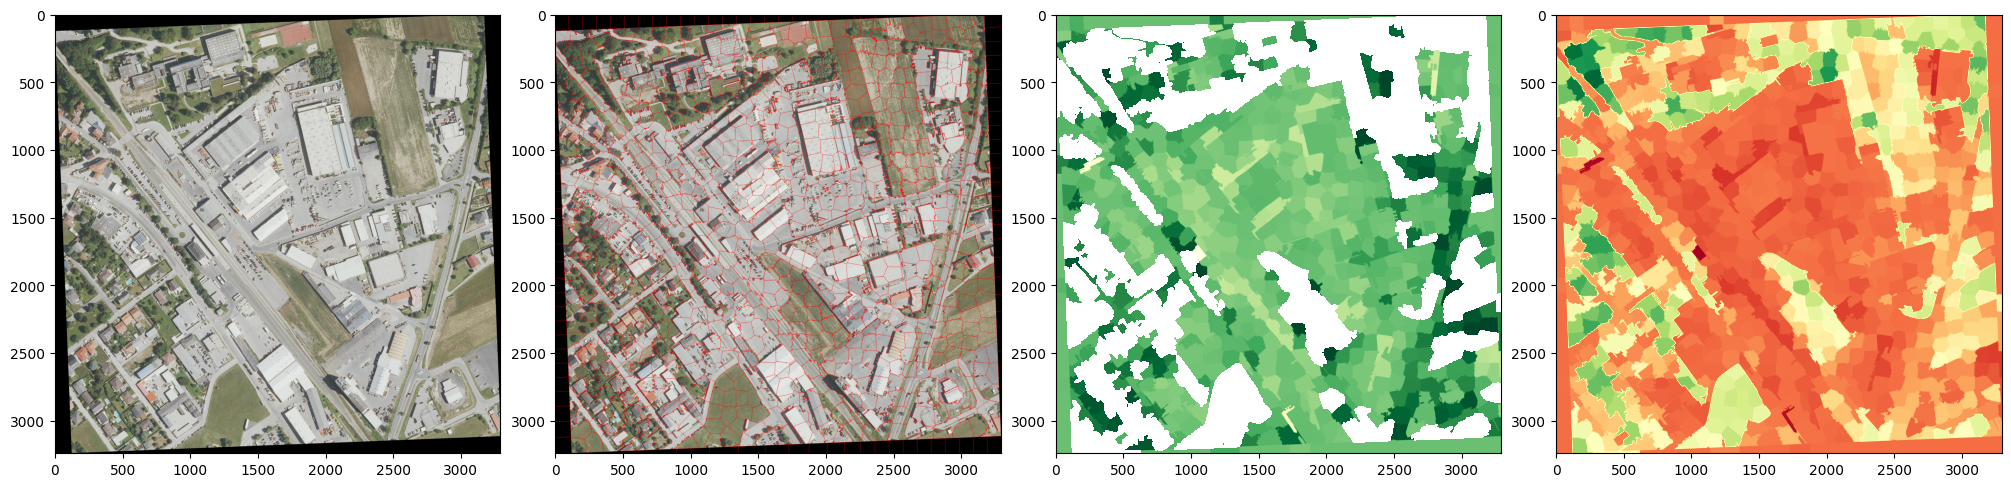

In [138]:
#plot the resultant images
fig, axs = plt.subplots(ncols=4, figsize=(20,10), constrained_layout=True)
axs[0].imshow(rgb)
axs[1].imshow(boundaries)
axs[3].imshow(mapped_ndvi, cmap="RdYlGn")
axs[2].imshow(impervious_surfaces, cmap='YlGn')

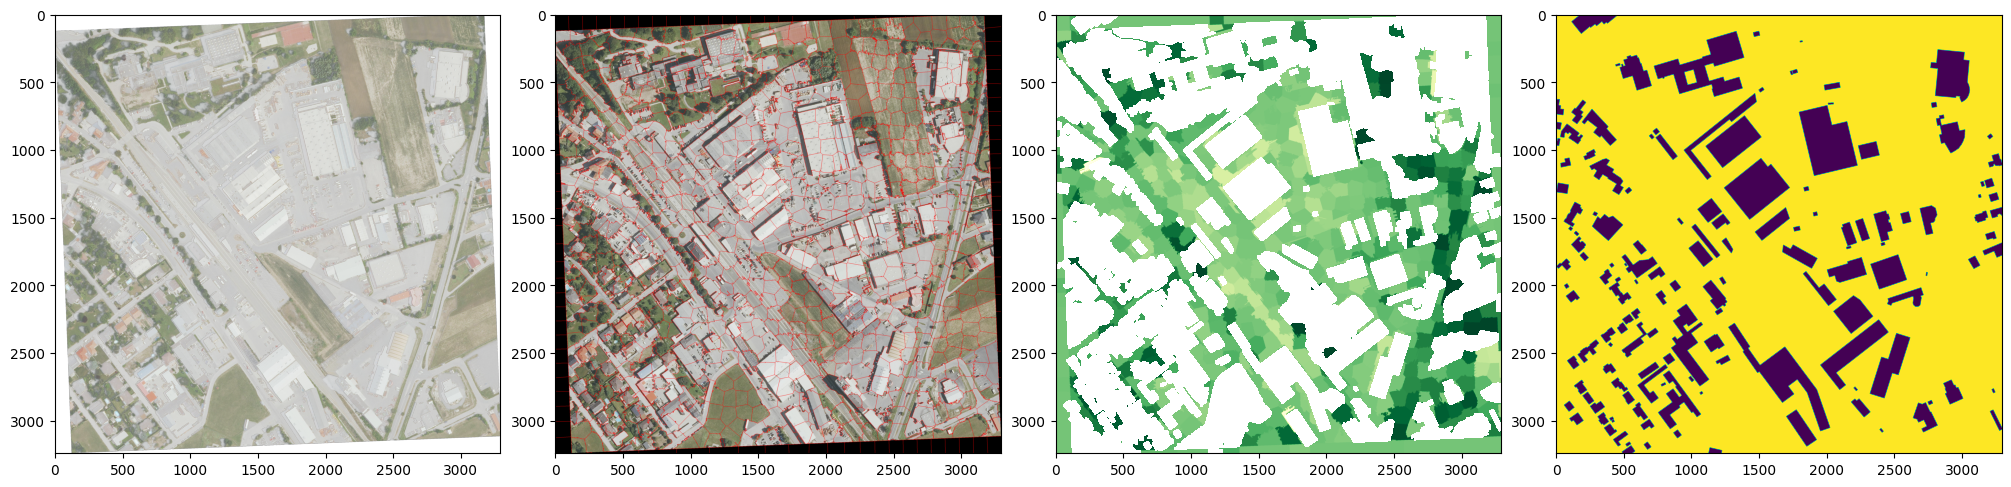

In [139]:

#create a building mask where pixels within the building are 0 and the rest 1
building_mask = geometry_mask([geom for geom in buildings.geometry], transform=src.transform, out_shape=image.shape[1:])

# Mask the impervious surfaces array with the building mask
impervious_surfaces_no_buildings = np.where(building_mask, impervious_surfaces, np.nan)

# Display the result
fig, axs = plt.subplots(ncols=4, figsize=(20,10), constrained_layout=True)
axs[0].imshow(image1)
axs[1].imshow(boundaries)
axs[2].imshow(impervious_surfaces_no_buildings, cmap='YlGn')
axs[3].imshow(building_mask)

In [140]:

impervious_mask = impervious_surfaces > 0  # Binary mask for impervious areas

# Calculate zonal statistics - sum of impervious pixels within each parcel polygon
stats = rasterstats.zonal_stats(parcels, impervious_surfaces_no_buildings, affine=src.transform, stats="sum", nodata=src.nodata)

# Add the impervious area (sum of impervious pixels) to the GeoDataFrame
parcels["impervious_area_pixels"] = [s['sum'] if s['sum'] is not None else 0 for s in stats]
parcels["impervious_area"] = parcels["impervious_area_pixels"]*0.4 #to compute area in real world units(m2) by multiplying by a pixel area (0.2m resolution)

# Calculate impervious area percentage
parcels["unsealing_potential"] = (parcels["impervious_area"] / parcels.area) * 100

In [141]:
parcels

KG      GNR RSTATUS  MST        layer  \
0    30120     1685       G    1  30120GST_V2   
1    30120     1691       G    1  30120GST_V2   
2    30120     1683       G    1  30120GST_V2   
3    30109    45/43       E    1  30109GST_V2   
4    30109      917       E    1  30109GST_V2   
..     ...      ...     ...  ...          ...   
230  30120   1686/2       G    1  30120GST_V2   
231  30109  949/171       E    1  30109GST_V2   
232  30109      937       E    1  30109GST_V2   
233  30120     1684       G    1  30120GST_V2   
234  30120    857/1       G    1  30120GST_V2   

                                                  path  \
0    /home/tanya/Documents/work/aws/cadaster_aut_20...   
1    /home/tanya/Documents/work/aws/cadaster_aut_20...   
2    /home/tanya/Documents/work/aws/cadaster_aut_20...   
3    /home/tanya/Documents/work/aws/cadaster_aut_20...   
4    /home/tanya/Documents/work/aws/cadaster_aut_20...   
..                                                 ...   
230  /home/tanya/Documents/work/aws/cadaster_aut_20...   
231  /home/tanya/Documents/work/aws/cadaster_aut_20...   
232  /home/tanya/Documents/work/aws/cadaster_aut_20...   
233  /home/tanya/Documents/work/aws/cadaster_aut_20...   
234  /home/tanya/Documents/work/aws/cadaster_aut_20...   

                                              geometry  \
0    POLYGON ((630904.040 430880.949, 630848.478 43...   
1    POLYGON ((630941.232 431108.698, 630947.057 43...   
2    POLYGON ((630888.559 430876.929, 630862.145 43...   
3    POLYGON ((630411.596 430991.595, 630415.776 43...   
4    POLYGON ((630463.215 431129.704, 630571.762 43...   
..                                                 ...   
230  POLYGON ((630922.176 430885.651, 630868.191 43...   
231  POLYGON ((630454.507 430597.547, 630482.957 43...   
232  POLYGON ((630383.099 431095.602, 630388.211 43...   
233  POLYGON ((630901.504 430880.291, 630845.717 43...   
234  POLYGON ((631054.557 430928.219, 631055.422 43...   

     impervious_area_pixels  impervious_area  unsealing_potential  
0               1942.824308       777.129723            27.483257  
1                 49.792107        19.916843             2.623491  
2               1582.842811       633.137124            19.511327  
3                 95.008951        38.003581            18.541116  
4                 73.064085        29.225634             3.392069  
..                      ...              ...                  ...  
230              563.055107       225.222043            21.928935  
231              311.202202       124.480881            13.344704  
232              144.021291        57.608517            19.834136  
233              335.357591       134.143037            21.339806  
234                0.445397         0.178159             0.017836  

[235 rows x 10 columns]

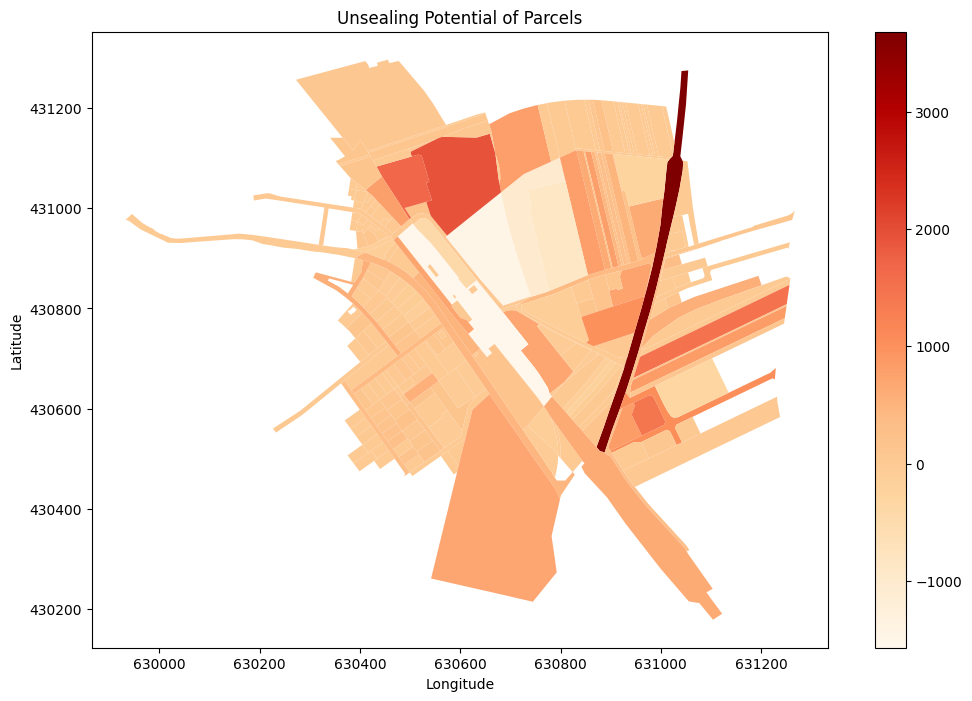

Shapefile with unsealing potential saved to /kaggle/working/parcels_unsealing_potential.shp


/tmp/ipykernel_30/3057166435.py:11: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  parcels.to_file(output_path)


In [142]:
# Plot the parcels showing unsealing potential
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
parcels.plot(column="impervious_area", cmap="OrRd", legend=True, ax=ax)
plt.title("Unsealing Potential of Parcels")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

# Save the updated GeoDataFrame with unsealing potential to a new shapefile

parcels.to_file(output_path)

print(f"Shapefile with unsealing potential saved to {output_path}")